In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from scipy.special import logit, expit
np.set_printoptions(precision=3)

%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

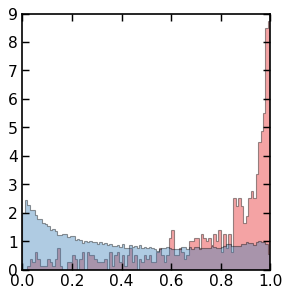

In [17]:
# nevent = 50000
sevent = 800
bevent = 50000

X = np.concatenate((expit(np.random.normal( 2.0,2.0,sevent)),
                    expit(np.random.normal(-0.5,2.0,bevent))))
M = np.concatenate((np.random.normal(125,1.7,sevent),
                    100+np.random.exponential(1/0.05,bevent)))
Y = np.concatenate((np.ones (sevent),
                    np.zeros(bevent)))
W = np.concatenate((0.1*expit(np.random.normal(2,2,sevent)),
                    5  *expit(np.random.exponential(2,bevent))
                   ))
W = np.concatenate( (np.ones(sevent),np.ones(bevent)) )

plt.figure(figsize=(4,4))
plt.hist(X[Y==1],bins=100, range=[0,1], alpha=0.4, weights=W[Y==1], histtype='stepfilled',lw=1, normed=True)
plt.hist(X[Y==0],bins=100, range=[0,1], alpha=0.4, weights=W[Y==0], histtype='stepfilled',lw=1, normed=True)
# plt.yscale('log')
plt.show()

In [18]:
df = pd.DataFrame(np.hstack((X.reshape (X.shape[0] , -1),
                             M.reshape (M.shape[0] , -1),
                             W.reshape (W.shape[0] , -1),
                             Y.reshape (Y.shape[0] , -1))), 
                  columns=['prob','mass','weight','target'])
df.head()

,prob,mass,weight,target
0,0.966404,123.131089,1.0,1.0
1,0.969420,124.499822,1.0,1.0
2,0.820857,123.554838,1.0,1.0
3,0.691326,127.397580,1.0,1.0
4,0.948624,125.173705,1.0,1.0


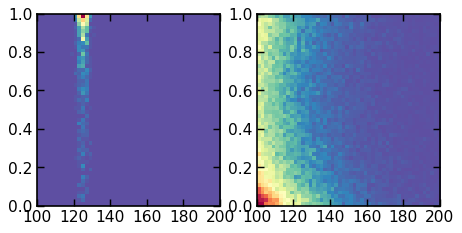

In [19]:
plt.figure(figsize=(6.5,3))
plt.subplot(121)
plt.hist2d(M[Y==1],X[Y==1],bins=[50,50], range=[[100,200],[0,1]],
           weights=W[Y==1],cmap=plt.cm.Spectral_r)
plt.subplot(122)
plt.hist2d(M[Y==0],X[Y==0],bins=[50,50], range=[[100,200],[0,1]],
           weights=W[Y==0],cmap=plt.cm.Spectral_r)
plt.show()

In [20]:
df.loc[:,'cat'] = pd.cut(df.prob, [0,0.5,0.8,0.99,1], labels= False)
np.unique(df.cat)

array([0, 1, 2, 3])

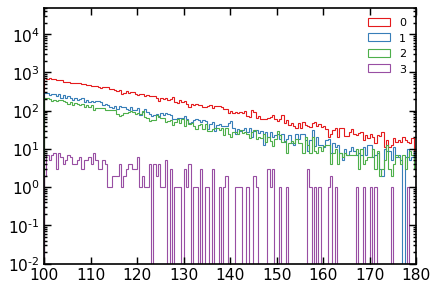

In [65]:
plt.figure(figsize=(6,4))
for i in np.unique(df.cat):
    plt.hist(df[(df.cat == i)&(df.target==0)].mass,bins=160, range=[100,180], 
             weights=df[(df.cat == i)&(df.target==0)].weight, 
             histtype='step',normed=False,
             lw=1,label=str(i) )
plt.yscale('log')
plt.ylim([0.01,bevent])
plt.legend()

In [29]:
import scipy.stats as st
from scipy.optimize import minimize

In [54]:
def exponotial(x, pos, lamb):
    return lamb * np.exp( -lamb * (x - pos) )

# def logpdf(params, data):
#     f, mu1,mu2, sigma, lamb = params
#     p1 = np.log(    expit(f)) + st.norm.logpdf (data, loc=mu1, scale=np.exp(sigma))
#     p2 = st.expon.logpdf(data, loc=mu2, scale=np.exp(lamb ))
#     return np.logaddexp(p1, p2)

def logpdf(params, data):
    f, mu2, lamb = params
    #     p1 = np.log(    expit(f)) + st.norm.logpdf (data, loc=mu1, scale=np.exp(sigma))
    p2 = st.expon.logpdf(data, loc=mu2, scale=np.exp(lamb ))
    return p2

def nll(params, data):
    out = -np.sum(logpdf(params, data))
    return out

In [55]:
_data_ = df.mass

def objective(x):
    params = x 
    out = nll(params, _data_)
    if np.isnan(out):
        raise ValueError("Illegal probability {}".format(params))
    return out

In [56]:
plt.figure(figsize=(6,4))
"N, f, mu1,mu2, sigma, lamb"
theta = np.linspace(100,180, 800)
plt.plot(theta, logpdf([0.1,125,100,1.5,4], theta),  lw=2)

ValueError: too many values to unpack

In [33]:
import numdifftools as nd

In [34]:
jaco = nd.Jacobian(objective) 
hess = nd.Hessian (objective)
print 'jacobian : '  , jaco([0.1,125,100,1.5,4])
print 'hessian  : \n', hess([0.1,125,100,1.5,4])

jacobian : 

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


 [[ -5015.328    642.555  17509.446  -6568.168  26213.597]]
hessian  : 
[[  1.760e+03   2.022e+02  -5.509e+02  -3.110e+03  -1.071e+03]
 [  2.022e+02   7.122e+00   1.526e+03   2.313e+02   4.215e+02]
 [ -5.509e+02   1.526e+03  -2.293e+03  -3.696e+04  -4.457e+02]
 [ -3.110e+03   2.313e+02  -3.696e+04  -1.911e+03  -4.107e+03]
 [ -1.071e+03   4.215e+02  -4.457e+02  -4.107e+03   1.265e+04]]


In [35]:
#out = minimize(objective, x0=[0.1,125,100,1.5,4], method='Newton-CG')

out = minimize(objective, x0=[0.1,125,100,2.5,4], method='Powell')
out

   direc: array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])
     fun: 171604.14728181969
 message: 'Optimization terminated successfully.'
    nfev: 162
     nit: 2
  status: 0
 success: True
       x: array([  76.664,  114.817,  100.002,    2.24 ,    3.174])

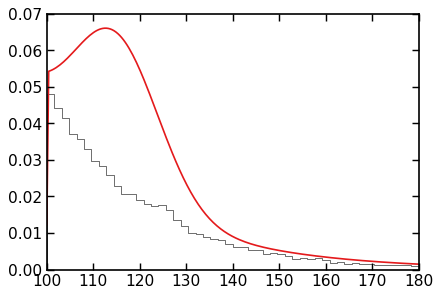

In [36]:
plt.figure(figsize=(6,4))
plt.hist(_data_, histtype='step', color='k', 
         bins=50, range=(100, 180), normed=True)

xs = np.linspace(100, 180, 200)
f = lambda xs: np.exp(logpdf(out.x, xs))
plt.plot(xs, f(xs))
# plt.yscale('log')
# plt.ylim([0.1, 100])

### Using IMINUIT

In [37]:
from iminuit import Minuit, describe, Struct

In [38]:
_data_ = df.mass

def objective_minuit(f, mu1,mu2, sigma, lamb):
    params = (f, mu1,mu2, sigma, lamb)
    out = nll(params, _data_)
    if np.isnan(out):
        raise ValueError("Illegal probability {}".format(params))
    return out

In [39]:
describe(objective_minuit)

['f', 'mu1', 'mu2', 'sigma', 'lamb']

In [40]:
m=Minuit(objective_minuit, 
         f=1.0, error_f = 0.001,
         mu1=125.0, error_mu1 = 0.01,
         mu2=100.0, error_mu2 = 0.01,
         sigma=0.3, error_sigma = 0.001,
         lamb=3, error_lamb = 0.001,
         fix_mu1 = True,
         print_level=1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: InitialParamWarning: errordef is not given. Default to 1.
  


In [41]:
m.print_param()

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,f,1,0.001,0,0,,,
2,mu1,125,0.01,0,0,,,FIXED
3,mu2,100,0.01,0,0,,,
4,sigma,0.3,0.001,0,0,,,
5,lamb,3,0.001,0,0,,,


In [42]:
m.migrad();

FCN = 172222.34783 
 TOTAL NCALL = 334 
 NCALLS = 334 
 
 
 EDM = 40.8715749854 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,f,13.8676,6.06168,0,0,,,
2,mu1,125,0.01,0,0,,,FIXED
3,mu2,100.002,0.000157038,0,0,,,
4,sigma,2.72182,0.0116673,0,0,,,
5,lamb,2.82869,0.0105559,0,0,,,


In [43]:
print ('parameters', m.parameters)
print ('args', m.args)
print ('value', m.values)

('parameters', ['f', 'mu1', 'mu2', 'sigma', 'lamb'])
('args', (13.86760445240944, 125.0, 100.00204596773126, 2.7218237702324326, 2.828692553915369))
('value', {'lamb': 2.828692553915369, 'sigma': 2.7218237702324326, 'mu2': 100.00204596773126, 'mu1': 125.0, 'f': 13.86760445240944})


In [44]:
#and function value at the minimum
print('fval', m.fval)
#Tip: you can also obtain value at current state by
print('current state', objective_minuit(*m.args))

('fval', 172222.34783029012)
('current state', 172222.34783029012)


In [45]:
m.print_matrix() #correlation

+,f,mu2,sigma,lamb
f,1.00,0.06,-0.00,-0.00
mu2,0.06,1.00,0.00,-0.00
sigma,-0.00,0.00,1.00,-0.36
lamb,-0.00,-0.00,-0.36,1.00


In [46]:
#minos contour
xminos, zminos, ctr = m.mncontour('sigma','lamb')

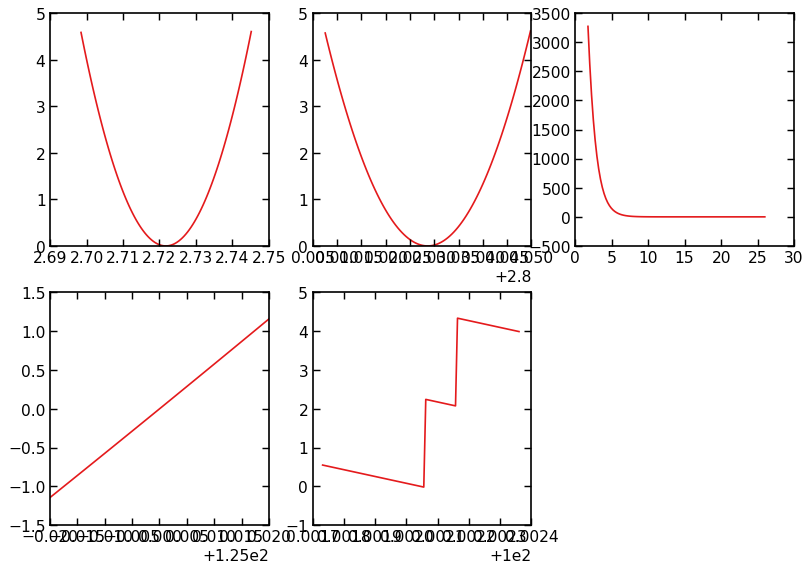

In [47]:
#1D value Scan
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
x,y = m.profile('sigma',subtract_min=True);
plt.plot(x,y) #if you have matplotlib

plt.subplot(2,3,2)
x,y = m.profile('lamb',subtract_min=True);
plt.plot(x,y) #if you have matplotlib

plt.subplot(2,3,3)
x,y = m.profile('f',subtract_min=True);
plt.plot(x,y) #if you have matplotlib

plt.subplot(2,3,4)
x,y = m.profile('mu1',subtract_min=True);
plt.plot(x,y) #if you have matplotlib

plt.subplot(2,3,5)
x,y = m.profile('mu2',subtract_min=True);
plt.plot(x,y) #if you have matplotlib